In [1]:
%load_ext autoreload
%autoreload 2

### Basic Imports

In [2]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [3]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [5]:
from scipy.optimize import minimize

### Ansatz State

In [6]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [7]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [8]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [9]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [10]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [11]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [12]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [13]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [14]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [15]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [16]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [17]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="TNC",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [18]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [19]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [20]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [21]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)
    initialize_approximated_energy_to_list_of_all_approximated_energies()

## Visualization

In [22]:
approximated_energies = []

In [23]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [24]:
def initialize_approximated_energy_to_list_of_all_approximated_energies():
    approximated_energies = []

In [25]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies)
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [26]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [27]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

27it [00:04,  5.62it/s]
27it [00:03,  8.01it/s]
27it [00:03,  8.34it/s]
27it [00:03,  8.46it/s]
27it [00:03,  8.28it/s]
27it [00:03,  8.58it/s]
27it [00:03,  8.54it/s]
27it [00:03,  8.02it/s]
27it [00:03,  8.07it/s]
27it [00:03,  7.69it/s]
27it [00:03,  7.15it/s]
27it [00:03,  7.69it/s]
27it [00:04,  6.65it/s]
27it [00:03,  8.11it/s]
27it [00:03,  8.28it/s]
27it [00:03,  8.15it/s]
27it [00:03,  8.11it/s]
27it [00:03,  7.97it/s]
27it [00:03,  8.28it/s]
27it [00:03,  8.49it/s]
27it [00:03,  8.49it/s]
27it [00:03,  8.21it/s]
27it [00:03,  7.72it/s]
27it [00:03,  8.06it/s]
27it [00:03,  7.95it/s]
27it [00:03,  7.83it/s]
27it [00:03,  8.01it/s]
27it [00:03,  8.34it/s]
27it [00:03,  8.45it/s]
27it [00:03,  7.25it/s]
27it [00:03,  7.19it/s]
27it [00:03,  7.90it/s]
27it [00:03,  8.27it/s]
27it [00:03,  7.90it/s]
27it [00:03,  8.49it/s]
27it [00:03,  8.14it/s]
27it [00:03,  7.96it/s]
27it [00:03,  7.86it/s]
27it [00:03,  8.66it/s]
27it [00:03,  8.45it/s]
27it [00:03,  8.16it/s]
27it [00:03,  7.

27it [00:03,  8.07it/s]
27it [00:03,  8.03it/s]
27it [00:03,  7.95it/s]
27it [00:03,  8.26it/s]
27it [00:03,  8.19it/s]
27it [00:03,  8.12it/s]
27it [00:03,  7.94it/s]
27it [00:03,  8.05it/s]
27it [00:03,  7.75it/s]
27it [00:03,  8.00it/s]
27it [00:03,  7.67it/s]
27it [00:03,  8.09it/s]
27it [00:03,  7.73it/s]
27it [00:03,  8.00it/s]
27it [00:03,  7.99it/s]
27it [00:03,  8.57it/s]
27it [00:03,  8.57it/s]
27it [00:03,  8.20it/s]
27it [00:03,  8.76it/s]
27it [00:03,  8.13it/s]
27it [00:03,  8.42it/s]
27it [00:03,  8.58it/s]
27it [00:03,  8.50it/s]
27it [00:03,  8.24it/s]
27it [00:03,  7.62it/s]
27it [00:03,  7.82it/s]
27it [00:03,  8.27it/s]
27it [00:03,  7.78it/s]
27it [00:03,  8.35it/s]
27it [00:03,  7.94it/s]
27it [00:03,  8.26it/s]
27it [00:03,  8.41it/s]
27it [00:03,  8.30it/s]
27it [00:03,  8.22it/s]
27it [00:03,  7.83it/s]
27it [00:03,  7.66it/s]
27it [00:03,  8.35it/s]
27it [00:03,  8.28it/s]
27it [00:03,  8.49it/s]
27it [00:03,  8.72it/s]
27it [00:03,  8.54it/s]
27it [00:03,  8.

27it [00:03,  8.21it/s]
27it [00:03,  8.14it/s]
27it [00:03,  8.01it/s]
27it [00:03,  8.18it/s]
27it [00:03,  7.42it/s]
27it [00:03,  7.84it/s]
27it [00:03,  8.04it/s]
27it [00:03,  8.14it/s]
27it [00:03,  7.81it/s]
27it [00:03,  8.09it/s]
27it [00:03,  7.63it/s]
27it [00:03,  8.33it/s]
27it [00:03,  8.39it/s]
27it [00:03,  8.62it/s]
27it [00:03,  8.29it/s]
27it [00:03,  7.89it/s]
27it [00:03,  8.15it/s]
27it [00:03,  8.09it/s]
27it [00:03,  7.65it/s]
27it [00:03,  7.99it/s]
27it [00:03,  7.98it/s]
27it [00:03,  7.79it/s]
27it [00:03,  8.15it/s]
27it [00:03,  7.87it/s]
27it [00:03,  7.76it/s]
27it [00:03,  7.92it/s]
27it [00:03,  7.92it/s]
27it [00:03,  8.07it/s]
27it [00:03,  7.91it/s]
27it [00:03,  7.92it/s]
27it [00:03,  7.79it/s]
27it [00:03,  8.03it/s]
27it [00:03,  7.98it/s]
27it [00:03,  7.98it/s]
27it [00:03,  7.99it/s]
27it [00:03,  7.82it/s]
27it [00:03,  7.81it/s]
27it [00:03,  8.40it/s]
27it [00:03,  7.87it/s]
27it [00:03,  8.09it/s]
27it [00:03,  8.13it/s]
27it [00:03,  7.

[4.90565733 3.74598732 0.84213267 2.64266029 3.9137949  2.63196832
 1.50233903 3.76640565 6.07714335 0.07254064 3.8319059  4.17987842
 3.17830556 1.36865036 2.66684308 0.1451689  3.72341903 5.56103435
 2.61593317 4.40018203 1.39542366 0.79042391 1.44314873 4.94384559
 1.61752383 0.07345695 4.67772566 5.73790877 4.97579146 3.88117492
 3.97823765 5.10873552]


27it [00:03,  8.00it/s]

CPU times: total: 44min 4s
Wall time: 48min 25s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.498106197506169

Approximation Error
0.046378924834883095


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


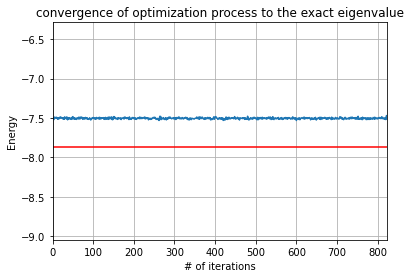

In [28]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [29]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

27it [00:03,  7.80it/s]
27it [00:03,  8.02it/s]
27it [00:03,  8.15it/s]
27it [00:03,  7.68it/s]
27it [00:03,  8.02it/s]
27it [00:03,  7.92it/s]
27it [00:03,  8.13it/s]
27it [00:03,  8.10it/s]
27it [00:03,  8.05it/s]
27it [00:03,  7.85it/s]
27it [00:03,  8.08it/s]
27it [00:03,  8.10it/s]
27it [00:03,  7.68it/s]
27it [00:03,  7.98it/s]
27it [00:03,  7.89it/s]
27it [00:03,  7.74it/s]
27it [00:03,  7.83it/s]
27it [00:03,  8.00it/s]
27it [00:03,  7.83it/s]
27it [00:03,  7.93it/s]
27it [00:03,  7.76it/s]
27it [00:03,  7.86it/s]
27it [00:03,  7.87it/s]
27it [00:03,  7.72it/s]
27it [00:03,  7.65it/s]
27it [00:03,  7.86it/s]
27it [00:03,  8.08it/s]
27it [00:03,  7.57it/s]
27it [00:03,  7.92it/s]
27it [00:03,  7.72it/s]
27it [00:03,  7.91it/s]
27it [00:03,  7.90it/s]
27it [00:03,  7.78it/s]
27it [00:03,  7.49it/s]
27it [00:03,  7.76it/s]
27it [00:03,  7.78it/s]
27it [00:03,  7.82it/s]
27it [00:03,  7.73it/s]
27it [00:03,  7.85it/s]
27it [00:03,  7.58it/s]
27it [00:03,  8.04it/s]
27it [00:03,  7.

27it [00:03,  7.58it/s]
27it [00:03,  7.68it/s]
27it [00:03,  7.62it/s]
27it [00:03,  7.28it/s]
27it [00:03,  7.55it/s]
27it [00:03,  7.57it/s]
27it [00:03,  7.78it/s]
27it [00:03,  7.90it/s]
27it [00:03,  7.40it/s]
27it [00:03,  7.67it/s]
27it [00:03,  7.31it/s]
27it [00:03,  7.43it/s]
27it [00:03,  7.78it/s]
27it [00:03,  7.28it/s]
27it [00:03,  7.96it/s]
27it [00:03,  7.77it/s]
27it [00:03,  8.44it/s]
27it [00:03,  7.54it/s]
27it [00:03,  7.52it/s]
27it [00:03,  7.04it/s]
27it [00:03,  7.53it/s]
27it [00:03,  7.60it/s]
27it [00:03,  7.89it/s]
27it [00:03,  7.64it/s]
27it [00:03,  7.70it/s]
27it [00:03,  7.42it/s]
27it [00:03,  7.88it/s]
27it [00:03,  7.66it/s]
27it [00:03,  7.64it/s]
27it [00:03,  7.96it/s]
27it [00:03,  7.69it/s]
27it [00:03,  7.02it/s]
27it [00:03,  7.93it/s]
27it [00:03,  8.07it/s]
27it [00:03,  7.94it/s]
27it [00:03,  7.86it/s]
27it [00:03,  7.54it/s]
27it [00:03,  7.55it/s]
27it [00:03,  7.89it/s]
27it [00:03,  8.16it/s]
27it [00:03,  7.76it/s]
27it [00:03,  7.

27it [00:04,  5.47it/s]
27it [00:04,  5.60it/s]
27it [00:04,  5.49it/s]
27it [00:04,  5.94it/s]
27it [00:04,  5.90it/s]
27it [00:04,  5.83it/s]
27it [00:04,  6.28it/s]
27it [00:04,  5.72it/s]
27it [00:04,  6.07it/s]
27it [00:04,  5.64it/s]
27it [00:04,  5.74it/s]
27it [00:04,  6.25it/s]
27it [00:04,  6.13it/s]
27it [00:04,  6.06it/s]
27it [00:04,  6.12it/s]
27it [00:04,  5.87it/s]
27it [00:04,  5.73it/s]
27it [00:04,  5.72it/s]
27it [00:04,  5.86it/s]
27it [00:04,  5.96it/s]
27it [00:04,  6.11it/s]
27it [00:04,  5.49it/s]
27it [00:04,  5.69it/s]
27it [00:04,  5.67it/s]
27it [00:04,  5.48it/s]
27it [00:04,  5.68it/s]
27it [00:04,  5.80it/s]
27it [00:04,  6.00it/s]
27it [00:04,  6.05it/s]
27it [00:03,  6.90it/s]
27it [00:04,  5.62it/s]
27it [00:04,  5.88it/s]
27it [00:04,  6.30it/s]
27it [00:04,  5.93it/s]
27it [00:05,  5.16it/s]
27it [00:04,  5.44it/s]
27it [00:05,  5.29it/s]
27it [00:04,  5.66it/s]
27it [00:04,  6.05it/s]
27it [00:04,  5.55it/s]
27it [00:04,  5.97it/s]
27it [00:04,  5.

27it [00:03,  8.96it/s]
27it [00:03,  8.86it/s]
27it [00:03,  8.22it/s]
27it [00:02,  9.01it/s]
27it [00:02,  9.42it/s]
27it [00:02,  9.18it/s]
27it [00:03,  8.73it/s]
27it [00:03,  8.43it/s]
27it [00:03,  8.47it/s]
27it [00:03,  8.60it/s]
27it [00:03,  8.64it/s]
27it [00:03,  8.11it/s]
27it [00:03,  7.77it/s]
27it [00:03,  8.50it/s]
27it [00:03,  8.65it/s]
27it [00:02,  9.11it/s]
27it [00:03,  8.38it/s]
27it [00:03,  8.86it/s]
27it [00:02,  9.18it/s]
27it [00:02,  9.37it/s]
27it [00:03,  8.78it/s]
27it [00:03,  8.47it/s]
27it [00:03,  8.53it/s]
27it [00:02,  9.03it/s]
27it [00:03,  8.15it/s]
27it [00:03,  8.77it/s]
27it [00:03,  8.35it/s]
27it [00:03,  8.14it/s]
27it [00:03,  8.52it/s]
27it [00:03,  8.63it/s]
27it [00:03,  8.57it/s]
27it [00:03,  8.62it/s]
27it [00:02, 10.37it/s]
27it [00:02, 10.26it/s]
27it [00:03,  8.90it/s]
27it [00:03,  8.93it/s]
27it [00:03,  8.86it/s]
27it [00:03,  8.47it/s]
27it [00:03,  8.65it/s]
27it [00:03,  8.34it/s]
27it [00:03,  8.34it/s]
27it [00:03,  8.

[5.95657423 0.97480863 4.7990964  3.37490212 0.93280147 0.94315356
 4.34427022 5.13481458 0.45909141 4.87161297 2.20670713 3.96911705
 0.98952008 5.81437377 4.10901475 4.33246267 1.43257595 2.86144409
 1.1140879  4.11432254 4.47341225 1.18521701 6.16678669 1.70441568
 4.30114475 3.27008351 4.94029201 3.29743223 3.44483282 1.66419636
 2.32454033 6.16704718]


27it [00:03,  8.24it/s]

CPU times: total: 1h 1min 28s
Wall time: 1h 13min 18s


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.4922794901850205

Approximation Error
0.04711997474187346


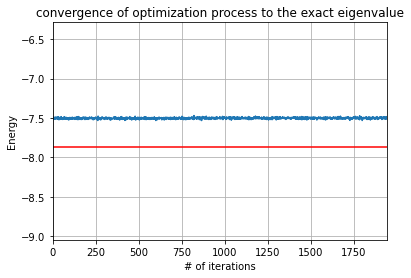

In [30]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [31]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [32]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

15it [00:01,  8.16it/s]
15it [00:01,  8.19it/s]
15it [00:01,  8.41it/s]
15it [00:01, 10.62it/s]
15it [00:01,  8.66it/s]
15it [00:01,  9.58it/s]
15it [00:01,  8.97it/s]
15it [00:01,  8.61it/s]
15it [00:01,  8.69it/s]
15it [00:01,  7.66it/s]
15it [00:01,  7.60it/s]
15it [00:02,  7.46it/s]
15it [00:02,  6.60it/s]
15it [00:01,  8.50it/s]
15it [00:01,  8.03it/s]
15it [00:02,  7.49it/s]
15it [00:01,  7.79it/s]
15it [00:02,  7.41it/s]
15it [00:02,  7.48it/s]
15it [00:02,  7.38it/s]
15it [00:01,  8.82it/s]
15it [00:01,  8.72it/s]
15it [00:01,  8.97it/s]
15it [00:01,  8.71it/s]
15it [00:01,  7.98it/s]
15it [00:01,  9.37it/s]
15it [00:01,  8.05it/s]
15it [00:01,  7.67it/s]
15it [00:01,  9.23it/s]
15it [00:01,  8.48it/s]
15it [00:01,  8.31it/s]
15it [00:02,  7.26it/s]
15it [00:01,  7.81it/s]
15it [00:01,  7.65it/s]
15it [00:01,  7.51it/s]
15it [00:01,  7.92it/s]
15it [00:02,  7.10it/s]
15it [00:01,  8.00it/s]
15it [00:01,  7.87it/s]
15it [00:01,  7.88it/s]
15it [00:01,  7.90it/s]
15it [00:01,  7.

15it [00:01,  9.47it/s]
15it [00:01,  8.16it/s]
15it [00:01,  8.64it/s]
15it [00:01,  9.16it/s]
15it [00:01,  8.00it/s]
15it [00:01,  8.27it/s]
15it [00:01,  9.01it/s]
15it [00:01,  7.84it/s]
15it [00:01,  8.61it/s]
15it [00:01,  8.80it/s]
15it [00:01,  8.83it/s]
15it [00:01,  8.59it/s]
15it [00:01,  7.98it/s]
15it [00:01,  7.57it/s]
15it [00:01,  8.30it/s]
15it [00:01,  8.39it/s]
15it [00:01,  9.32it/s]
15it [00:01,  9.86it/s]
15it [00:01,  8.15it/s]
15it [00:01,  9.13it/s]
15it [00:01,  8.22it/s]
15it [00:01,  8.35it/s]


[5.58683609 1.1214092  2.01522197 0.48114486 1.60165901 4.52726666
 0.39116347 6.23257826 3.07873061 4.45656586 0.13057521 3.69420876
 2.71410757 2.83544051 0.79408123 4.46842194 2.71971045 5.58963795
 0.7457607  1.85868041 4.6741783  2.99370922 1.45884361 1.04284367
 4.59753025 5.5189104  0.39184924 1.71540789 3.1312719  4.0729707
 5.53343339 0.2140833 ]


15it [00:01,  9.03it/s]

CPU times: total: 10min 5s
Wall time: 10min 21s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-0.7989887536531474

Approximation Error
0.5698059034551899


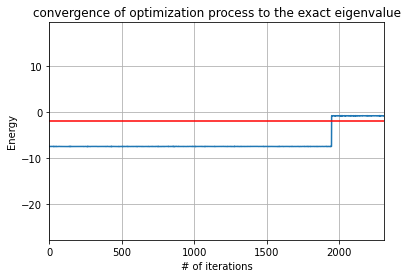

In [33]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [34]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

15it [00:01,  8.46it/s]
15it [00:01,  8.41it/s]
15it [00:01,  8.41it/s]
15it [00:01,  8.09it/s]
15it [00:01,  8.47it/s]
15it [00:01,  7.69it/s]
15it [00:01,  8.51it/s]
15it [00:01,  8.40it/s]
15it [00:01,  8.34it/s]
15it [00:01,  8.42it/s]
15it [00:01,  8.56it/s]
15it [00:01,  8.57it/s]
15it [00:01,  7.98it/s]
15it [00:01,  8.92it/s]
15it [00:01,  8.57it/s]
15it [00:01,  8.46it/s]
15it [00:01,  8.05it/s]
15it [00:01,  7.77it/s]
15it [00:01,  8.29it/s]
15it [00:01,  7.98it/s]
15it [00:01,  8.57it/s]
15it [00:01,  8.02it/s]
15it [00:01,  8.03it/s]
15it [00:01,  8.98it/s]
15it [00:01,  8.83it/s]
15it [00:01,  7.56it/s]
15it [00:01,  8.23it/s]
15it [00:01,  8.21it/s]
15it [00:01,  9.27it/s]
15it [00:01,  8.45it/s]
15it [00:01,  9.04it/s]
15it [00:01,  9.95it/s]
15it [00:01,  9.22it/s]
15it [00:01,  8.46it/s]
15it [00:01,  9.12it/s]
15it [00:01,  9.72it/s]
15it [00:01,  8.24it/s]
15it [00:01,  7.91it/s]
15it [00:01,  8.08it/s]
15it [00:01,  8.17it/s]
15it [00:01,  9.07it/s]
15it [00:01,  8.

[4.81012833 3.57904717 3.8915462  3.85983924 3.74013796 5.66804736
 1.67558175 3.89198411 1.20731595 2.75865882 2.4740476  4.82725002
 2.22495778 3.63080991 2.68147095 2.2396625  2.39679298 1.56871841
 5.14621673 1.97904101 3.99880447 5.6590905  0.92823301 0.80007799
 4.4476988  0.57303328 2.8814743  5.36724743 2.81998961 3.38607664
 4.38538051 4.55556045]


15it [00:01,  9.26it/s]

CPU times: total: 7min 35s
Wall time: 7min 45s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-0.9192218791989978

Approximation Error
0.5050695969897178


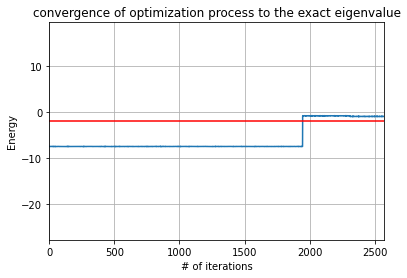

In [35]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [36]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [37]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

11it [00:01,  8.63it/s]
11it [00:01,  9.24it/s]
11it [00:01,  9.04it/s]
11it [00:01,  7.73it/s]
11it [00:01,  9.71it/s]
11it [00:01,  9.75it/s]
11it [00:01,  8.61it/s]
11it [00:01,  8.99it/s]
11it [00:01,  9.36it/s]
11it [00:01, 10.37it/s]
11it [00:01, 10.49it/s]
11it [00:01,  9.30it/s]
11it [00:01,  9.00it/s]
11it [00:01,  8.85it/s]
11it [00:01,  8.84it/s]
11it [00:01,  8.85it/s]
11it [00:01,  7.89it/s]
11it [00:01, 10.38it/s]
11it [00:01,  7.70it/s]
11it [00:01,  8.56it/s]
11it [00:01,  8.84it/s]
11it [00:01,  9.28it/s]
11it [00:01,  9.23it/s]
11it [00:01,  8.68it/s]
11it [00:01,  7.91it/s]
11it [00:01,  8.79it/s]
11it [00:01,  8.90it/s]
11it [00:01,  8.79it/s]
11it [00:01,  8.16it/s]
11it [00:01,  8.62it/s]
11it [00:01,  9.74it/s]
11it [00:01,  9.06it/s]
11it [00:01,  9.26it/s]
11it [00:01,  8.93it/s]
11it [00:01,  8.14it/s]
11it [00:01,  9.29it/s]
11it [00:01,  7.38it/s]
11it [00:01,  8.47it/s]
11it [00:01,  8.33it/s]
11it [00:01,  8.36it/s]
11it [00:01,  8.45it/s]
11it [00:01,  8.

11it [00:01,  9.25it/s]
11it [00:01,  9.48it/s]
11it [00:01,  9.64it/s]
11it [00:01,  8.81it/s]
11it [00:01,  9.94it/s]
11it [00:01,  8.81it/s]
11it [00:01, 10.02it/s]
11it [00:01,  9.38it/s]
11it [00:01,  9.18it/s]
11it [00:01,  7.86it/s]
11it [00:01,  9.45it/s]
11it [00:01,  8.44it/s]
11it [00:01,  8.96it/s]
11it [00:01,  7.54it/s]
11it [00:01,  8.24it/s]
11it [00:01,  8.32it/s]
11it [00:01,  8.04it/s]
11it [00:01,  9.86it/s]
11it [00:01,  8.65it/s]
11it [00:01,  9.28it/s]
11it [00:01,  8.04it/s]
11it [00:01,  9.68it/s]


[1.98350733 3.68094169 2.89383691 2.82576224 4.66950841 3.02642524
 6.08678784 3.55127461 1.40963502 0.52883121 0.69743894 0.08470143
 1.42443369 4.65646884 3.83751766 2.8259762  5.96166683 0.90574903
 0.74633159 1.34984319 2.29023494 3.23209011 3.59004244 2.55174977
 4.75814054 5.52515029 1.57917839 1.42618139 3.08890322 4.44402162
 1.23827244 2.12177759]


11it [00:01,  9.54it/s]

CPU times: total: 7min 27s
Wall time: 7min 37s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
0.008543989546709131

Approximation Error
0.9957269061442461


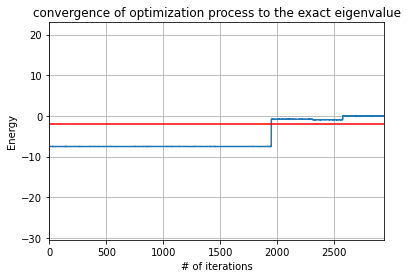

In [38]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [39]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

11it [00:01,  9.17it/s]
11it [00:01,  8.06it/s]
11it [00:01,  7.96it/s]
11it [00:01,  8.72it/s]
11it [00:01,  8.22it/s]
11it [00:01,  9.22it/s]
11it [00:01,  8.38it/s]
11it [00:01,  7.83it/s]
11it [00:01,  8.33it/s]
11it [00:01,  8.07it/s]
11it [00:01,  7.98it/s]
11it [00:01,  9.42it/s]
11it [00:01,  8.21it/s]
11it [00:01,  8.45it/s]
11it [00:01,  7.58it/s]
11it [00:01,  8.45it/s]
11it [00:01,  8.64it/s]
11it [00:01,  9.38it/s]
11it [00:01,  9.27it/s]
11it [00:01,  8.04it/s]
11it [00:01,  8.51it/s]
11it [00:01,  7.79it/s]
11it [00:01,  9.42it/s]
11it [00:01,  8.37it/s]
11it [00:01,  8.30it/s]
11it [00:01,  8.28it/s]
11it [00:01,  8.58it/s]
11it [00:01,  8.54it/s]
11it [00:01, 10.24it/s]
11it [00:01,  9.50it/s]
11it [00:01,  9.33it/s]
11it [00:01,  7.88it/s]
11it [00:01,  6.68it/s]
11it [00:01,  8.42it/s]
11it [00:01,  9.06it/s]
11it [00:01,  8.94it/s]
11it [00:01,  7.96it/s]
11it [00:01,  9.28it/s]
11it [00:01,  8.15it/s]
11it [00:01,  7.87it/s]
11it [00:01, 10.71it/s]
11it [00:01,  9.

11it [00:01,  7.16it/s]
11it [00:01,  7.63it/s]
11it [00:01,  8.18it/s]
11it [00:01,  7.35it/s]
11it [00:01,  7.01it/s]
11it [00:01,  8.31it/s]
11it [00:01,  8.87it/s]
11it [00:01,  8.77it/s]
11it [00:01,  7.77it/s]
11it [00:01,  8.84it/s]
11it [00:01,  8.47it/s]
11it [00:01,  7.25it/s]
11it [00:01,  6.77it/s]
11it [00:01,  7.29it/s]
11it [00:01,  7.02it/s]
11it [00:01,  8.81it/s]
11it [00:01,  9.06it/s]
11it [00:01,  8.35it/s]
11it [00:01,  8.06it/s]
11it [00:01,  7.38it/s]
11it [00:01,  6.34it/s]
11it [00:01,  7.00it/s]
11it [00:01,  6.00it/s]
11it [00:01,  5.66it/s]
11it [00:01,  6.89it/s]
11it [00:01,  6.84it/s]
11it [00:01,  6.43it/s]
11it [00:01,  8.09it/s]
11it [00:01,  7.25it/s]
11it [00:01,  7.89it/s]
11it [00:01,  6.85it/s]
11it [00:01,  6.47it/s]
11it [00:01,  7.06it/s]
11it [00:01,  5.95it/s]
11it [00:01,  5.77it/s]
11it [00:01,  6.77it/s]
11it [00:01,  6.79it/s]
11it [00:01,  6.84it/s]
11it [00:01,  8.31it/s]
11it [00:01,  7.27it/s]
11it [00:01,  7.26it/s]
11it [00:01,  7.

11it [00:01,  8.18it/s]
11it [00:01,  7.42it/s]
11it [00:01,  7.23it/s]
11it [00:01,  8.03it/s]
11it [00:01,  8.30it/s]
11it [00:01,  6.97it/s]
11it [00:01,  7.78it/s]
11it [00:01,  7.80it/s]
11it [00:01,  8.80it/s]
11it [00:01,  9.34it/s]
11it [00:01,  8.63it/s]
11it [00:01,  8.63it/s]
11it [00:01,  8.92it/s]
11it [00:01,  8.49it/s]
11it [00:01,  9.43it/s]
11it [00:01,  9.73it/s]
11it [00:01,  8.77it/s]
11it [00:01, 10.53it/s]
11it [00:01, 10.31it/s]
11it [00:01,  8.97it/s]
11it [00:01,  9.38it/s]
11it [00:01,  9.34it/s]
11it [00:01, 10.09it/s]
11it [00:01,  9.84it/s]
11it [00:01,  8.43it/s]
11it [00:01,  9.84it/s]
11it [00:01,  9.28it/s]
11it [00:01,  9.25it/s]
11it [00:01,  9.25it/s]
11it [00:01, 10.46it/s]
11it [00:01,  9.42it/s]
11it [00:01,  8.94it/s]
11it [00:01,  8.50it/s]
11it [00:01,  9.08it/s]
11it [00:01,  9.54it/s]
11it [00:01,  9.74it/s]
11it [00:01,  9.15it/s]
11it [00:01, 10.47it/s]
11it [00:01,  8.60it/s]
11it [00:01, 10.05it/s]
11it [00:01,  8.58it/s]
11it [00:01,  9.

[5.34624947 4.02304426 4.74167689 1.17433427 5.03124012 5.36768868
 1.96322334 0.10675793 2.05191471 1.79562958 1.69587276 5.5547992
 4.46846723 2.718503   2.80366129 1.88729667 0.30506228 0.21160555
 3.2688326  1.59878699 1.36323337 1.26301139 3.78505232 1.15133375
 1.73522574 2.15786087 2.00636822 3.21263315 4.61393033 2.02974609
 3.85361364 4.18484745]


11it [00:01,  9.49it/s]

CPU times: total: 20min 56s
Wall time: 1h 46min 29s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-0.6899176197943885

Approximation Error
0.6549524404257643


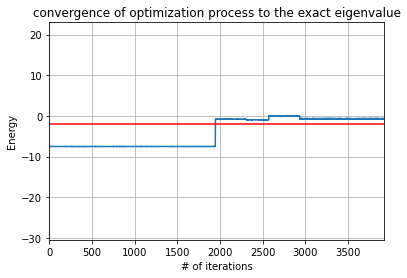

In [40]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [41]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [42]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [43]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

7it [00:00, 10.22it/s]
7it [00:00, 12.38it/s]
7it [00:00, 13.49it/s]
7it [00:00, 11.88it/s]
7it [00:00, 11.47it/s]
7it [00:00, 12.82it/s]
7it [00:00, 11.94it/s]
7it [00:00, 12.11it/s]
7it [00:00, 15.08it/s]
7it [00:00, 10.62it/s]
7it [00:00, 10.72it/s]
7it [00:00, 11.76it/s]
7it [00:00, 10.33it/s]
7it [00:00, 12.08it/s]
7it [00:00, 10.11it/s]
7it [00:00, 14.05it/s]
7it [00:00, 11.50it/s]
7it [00:00, 11.29it/s]
7it [00:00, 10.77it/s]
7it [00:00, 12.59it/s]
7it [00:00, 12.86it/s]
7it [00:00, 12.69it/s]
7it [00:00, 10.73it/s]
7it [00:00, 11.26it/s]
7it [00:00,  9.18it/s]
7it [00:00,  9.02it/s]
7it [00:00,  7.07it/s]
7it [00:00, 11.84it/s]
7it [00:00, 13.45it/s]
7it [00:00, 12.42it/s]
7it [00:00, 12.18it/s]
7it [00:00, 11.04it/s]
7it [00:00, 12.14it/s]
7it [00:00, 11.77it/s]
7it [00:00, 11.79it/s]
7it [00:00,  9.88it/s]
7it [00:00, 11.89it/s]
7it [00:00, 13.44it/s]
7it [00:00, 13.63it/s]
7it [00:00, 11.71it/s]
7it [00:00, 12.82it/s]
7it [00:00, 11.42it/s]
7it [00:00, 13.79it/s]
7it [00:00,

[5.47046573 5.63448605 6.05139358 2.46762371 0.28262514 0.74633934
 4.14896136 4.13657994 1.49798207 2.10542973 0.02944417 5.24814258
 5.17218032 2.48312934 4.0900247  5.86793868 2.01621663 3.44919195
 3.1736121  4.11074793 0.25429064 3.07451463 0.92130011 2.88235509]


7it [00:00, 11.55it/s]

CPU times: total: 1min 8s
Wall time: 1min 14s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.09546669667028986

Approximation Error
0.9157183398694355


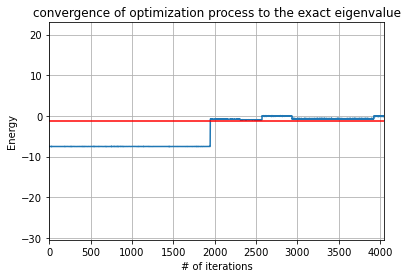

In [44]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [45]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

7it [00:00, 11.78it/s]
7it [00:00, 12.49it/s]
7it [00:00, 12.52it/s]
7it [00:00, 10.98it/s]
7it [00:00, 11.80it/s]
7it [00:00, 11.61it/s]
7it [00:00, 11.90it/s]
7it [00:00, 12.31it/s]
7it [00:00, 10.49it/s]
7it [00:00, 11.14it/s]
7it [00:00, 11.42it/s]
7it [00:00, 11.33it/s]
7it [00:00, 11.99it/s]
7it [00:00, 13.27it/s]
7it [00:00, 13.09it/s]
7it [00:00, 13.62it/s]
7it [00:00, 12.40it/s]
7it [00:00, 11.78it/s]
7it [00:00, 11.14it/s]
7it [00:00, 12.63it/s]
7it [00:00, 11.87it/s]
7it [00:00, 12.45it/s]
7it [00:00, 11.39it/s]
7it [00:00, 12.34it/s]
7it [00:00, 12.70it/s]
7it [00:00, 10.89it/s]
7it [00:00, 10.63it/s]
7it [00:00, 11.39it/s]
7it [00:00, 13.45it/s]
7it [00:00, 14.21it/s]
7it [00:00, 12.02it/s]
7it [00:00, 12.06it/s]
7it [00:00, 11.09it/s]
7it [00:00, 12.00it/s]
7it [00:00, 10.24it/s]
7it [00:00, 12.71it/s]
7it [00:00,  9.12it/s]
7it [00:00, 12.64it/s]
7it [00:00, 10.17it/s]
7it [00:00, 10.98it/s]
7it [00:00, 10.86it/s]
7it [00:00, 12.50it/s]
7it [00:00, 13.17it/s]
7it [00:00,

[3.89146223 1.4370183  4.15231739 5.752212   5.52186286 4.00036703
 3.18788629 5.2863585  1.43760331 2.31788259 1.53358707 1.31969943
 0.13677534 1.46023595 6.00189632 2.35021454 5.41067151 1.38053667
 1.65417328 2.24856939 3.60238172 2.18266564 2.57452293 4.72857609]


7it [00:00,  9.83it/s]

CPU times: total: 57.6 s
Wall time: 1min 2s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
0.27082379759932507

Approximation Error
0.7609063677633399


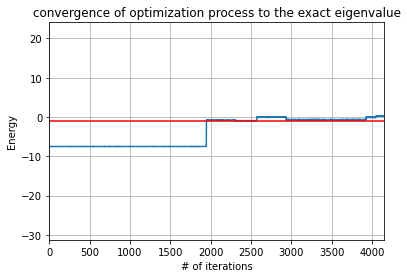

In [46]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [47]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [48]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [49]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

3it [00:00, 12.53it/s]
3it [00:00, 14.11it/s]
3it [00:00, 14.36it/s]
3it [00:00, 17.96it/s]
3it [00:00, 14.42it/s]
3it [00:00, 14.92it/s]
3it [00:00, 19.95it/s]
3it [00:00, 15.51it/s]
3it [00:00, 13.91it/s]
3it [00:00, 12.74it/s]
3it [00:00, 14.37it/s]
3it [00:00, 15.61it/s]
3it [00:00, 15.63it/s]
3it [00:00, 21.37it/s]
3it [00:00, 12.87it/s]
3it [00:00, 15.19it/s]
3it [00:00, 14.92it/s]
3it [00:00, 12.97it/s]
3it [00:00, 14.27it/s]
3it [00:00, 17.17it/s]
3it [00:00, 14.74it/s]
3it [00:00, 16.30it/s]
3it [00:00, 17.95it/s]
3it [00:00, 18.47it/s]
3it [00:00, 11.21it/s]
3it [00:00, 15.69it/s]
3it [00:00, 19.34it/s]
3it [00:00, 13.58it/s]
3it [00:00, 14.97it/s]
3it [00:00, 16.95it/s]
3it [00:00,  9.58it/s]
3it [00:00, 14.94it/s]
3it [00:00, 18.01it/s]
3it [00:00, 14.56it/s]
3it [00:00, 16.65it/s]
3it [00:00, 16.70it/s]
3it [00:00, 14.65it/s]
3it [00:00, 14.21it/s]
3it [00:00, 13.92it/s]
3it [00:00, 14.75it/s]
3it [00:00, 14.11it/s]
3it [00:00, 12.55it/s]
3it [00:00, 14.59it/s]
3it [00:00,

3it [00:00, 12.02it/s]
3it [00:00, 13.07it/s]
3it [00:00, 11.90it/s]
3it [00:00, 11.43it/s]
3it [00:00, 10.88it/s]
3it [00:00, 11.22it/s]
3it [00:00,  9.32it/s]
3it [00:00, 11.61it/s]
3it [00:00,  8.93it/s]
3it [00:00, 12.47it/s]
3it [00:00, 10.04it/s]
3it [00:00, 11.88it/s]
3it [00:00, 12.51it/s]
3it [00:00, 11.52it/s]
3it [00:00, 12.25it/s]
3it [00:00, 15.02it/s]
3it [00:00,  9.72it/s]
3it [00:00, 11.99it/s]
3it [00:00, 12.56it/s]
3it [00:00, 10.07it/s]
3it [00:00, 14.53it/s]
3it [00:00, 10.12it/s]
3it [00:00, 10.86it/s]
3it [00:00, 11.93it/s]
3it [00:00, 12.79it/s]
3it [00:00, 13.89it/s]
3it [00:00, 10.14it/s]
3it [00:00, 10.94it/s]
3it [00:00, 12.78it/s]
3it [00:00,  9.18it/s]
3it [00:00, 10.29it/s]
3it [00:00,  9.47it/s]
3it [00:00, 10.64it/s]
3it [00:00, 11.02it/s]
3it [00:00, 12.79it/s]


[2.76166685 5.59282277 6.25845098 6.05951357 3.45350564 3.91223671
 5.28309963 3.58947643 2.16997112 4.23824132 3.97542847 1.82830191
 5.34821839 6.26459838 0.90222577 5.52897125]


3it [00:00, 13.24it/s]

CPU times: total: 1min 25s
Wall time: 1min 33s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-0.30919558209744213

Approximation Error
0.6989257479766504


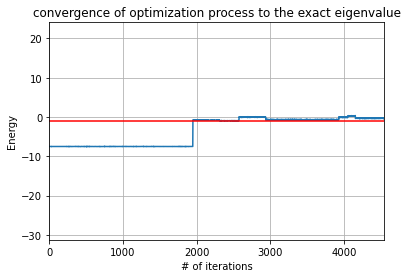

In [50]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [51]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

3it [00:00, 11.55it/s]
3it [00:00,  9.25it/s]
3it [00:00, 11.29it/s]
3it [00:00, 10.85it/s]
3it [00:00, 10.52it/s]
3it [00:00, 16.21it/s]
3it [00:00, 11.70it/s]
3it [00:00, 11.57it/s]
3it [00:00, 12.96it/s]
3it [00:00,  9.34it/s]
3it [00:00, 11.53it/s]
3it [00:00, 10.43it/s]
3it [00:00, 13.16it/s]
3it [00:00, 10.21it/s]
3it [00:00,  9.23it/s]
3it [00:00, 10.53it/s]
3it [00:00, 11.18it/s]
3it [00:00, 10.97it/s]
3it [00:00, 12.53it/s]
3it [00:00, 10.67it/s]
3it [00:00, 13.43it/s]
3it [00:00, 14.01it/s]
3it [00:00, 11.99it/s]
3it [00:00, 12.53it/s]
3it [00:00, 13.39it/s]
3it [00:00, 10.76it/s]
3it [00:00, 12.66it/s]
3it [00:00, 11.05it/s]
3it [00:00, 11.41it/s]
3it [00:00, 12.23it/s]
3it [00:00,  9.67it/s]
3it [00:00, 11.19it/s]
3it [00:00,  9.72it/s]
3it [00:00, 11.62it/s]
3it [00:00, 11.08it/s]
3it [00:00, 12.67it/s]
3it [00:00, 12.04it/s]
3it [00:00, 10.37it/s]
3it [00:00, 12.16it/s]
3it [00:00, 12.15it/s]
3it [00:00,  9.33it/s]
3it [00:00, 13.22it/s]
3it [00:00, 10.23it/s]
3it [00:00,

3it [00:00, 12.97it/s]


[2.59548749 2.21551333 0.23493551 0.24146075 3.0580773  3.34442278
 6.27658243 3.43853516 5.06230041 2.48539821 3.77287666 3.93872536
 1.87544305 0.80388178 2.71620626 5.49951353]


3it [00:00, 13.28it/s]

CPU times: total: 1min 21s
Wall time: 1min 29s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
0.1740527391907506

Approximation Error
0.8305189294459072


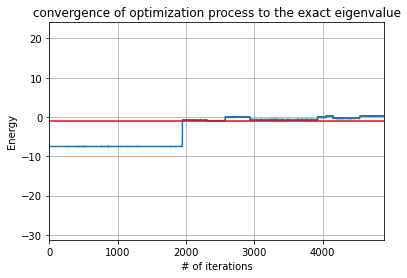

In [52]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [53]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [54]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

4it [00:00, 13.21it/s]
4it [00:00, 11.36it/s]
4it [00:00, 14.35it/s]
4it [00:00, 13.32it/s]
4it [00:00,  9.70it/s]
4it [00:00, 13.35it/s]
4it [00:00, 13.11it/s]
4it [00:00, 11.96it/s]
4it [00:00, 13.07it/s]
4it [00:00, 12.14it/s]
4it [00:00, 13.62it/s]
4it [00:00, 11.98it/s]
4it [00:00, 11.83it/s]
4it [00:00, 14.00it/s]
4it [00:00, 10.61it/s]
4it [00:00, 12.98it/s]
4it [00:00, 11.21it/s]
4it [00:00, 12.54it/s]
4it [00:00, 10.30it/s]
4it [00:00, 14.77it/s]
4it [00:00, 12.52it/s]
4it [00:00, 10.41it/s]
4it [00:00, 12.14it/s]
4it [00:00, 12.35it/s]
4it [00:00,  9.75it/s]
4it [00:00, 11.22it/s]
4it [00:00, 11.43it/s]
4it [00:00, 15.52it/s]
4it [00:00, 10.63it/s]
4it [00:00, 14.81it/s]
4it [00:00,  9.87it/s]
4it [00:00, 12.53it/s]
4it [00:00, 11.95it/s]
4it [00:00, 14.06it/s]
4it [00:00, 11.11it/s]
4it [00:00, 10.03it/s]
4it [00:00, 12.89it/s]
4it [00:00, 13.87it/s]
4it [00:00, 13.41it/s]
4it [00:00, 13.36it/s]
4it [00:00, 13.37it/s]
4it [00:00, 11.83it/s]
4it [00:00, 11.35it/s]
4it [00:00,

[4.94558284 0.15823702 4.86323715 3.28460428 4.64177532 2.5763609
 3.15314567 3.04086926 2.37133746 2.77726072 4.04283071 0.35331417
 1.70803683 0.71929127 5.88799473 1.4834504 ]


4it [00:00, 11.21it/s]

CPU times: total: 1min 3s
Wall time: 1min 11s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.6237734834790576

Approximation Error
0.37939575922784907


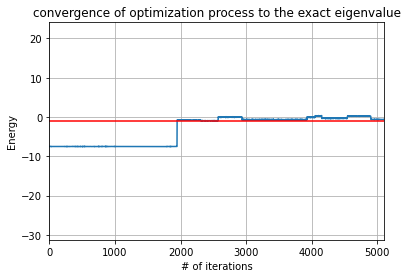

In [55]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [56]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

4it [00:00, 11.30it/s]
4it [00:00, 12.69it/s]
4it [00:00, 11.59it/s]
4it [00:00, 12.14it/s]
4it [00:00, 10.58it/s]
4it [00:00, 12.96it/s]
4it [00:00, 10.86it/s]
4it [00:00, 11.83it/s]
4it [00:00, 10.44it/s]
4it [00:00, 13.14it/s]
4it [00:00, 10.47it/s]
4it [00:00, 12.57it/s]
4it [00:00, 10.84it/s]
4it [00:00, 15.33it/s]
4it [00:00, 10.60it/s]
4it [00:00, 13.54it/s]
4it [00:00, 11.08it/s]
4it [00:00, 13.31it/s]
4it [00:00, 12.00it/s]
4it [00:00, 13.40it/s]
4it [00:00, 11.36it/s]
4it [00:00, 11.76it/s]
4it [00:00, 11.75it/s]
4it [00:00, 13.83it/s]
4it [00:00, 11.94it/s]
4it [00:00, 15.41it/s]
4it [00:00, 14.60it/s]
4it [00:00, 10.94it/s]
4it [00:00,  9.17it/s]
4it [00:00, 13.14it/s]
4it [00:00, 11.90it/s]
4it [00:00, 15.11it/s]
4it [00:00, 11.91it/s]
4it [00:00, 13.03it/s]
4it [00:00, 12.91it/s]
4it [00:00, 14.30it/s]
4it [00:00, 12.41it/s]
4it [00:00, 13.81it/s]
4it [00:00, 13.84it/s]
4it [00:00, 11.90it/s]
4it [00:00, 14.61it/s]
4it [00:00, 12.73it/s]
4it [00:00, 11.85it/s]
4it [00:00,

[4.04637152 4.56852076 2.1760247  3.92484758 6.06443346 1.43489241
 5.72849806 1.64210014 6.2540165  1.41119844 0.34223303 5.32710966
 1.11454042 0.84110811 0.1399586  5.04209668]


4it [00:00, 11.85it/s]

CPU times: total: 1min 43s
Wall time: 1min 57s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.3834434568780627

Approximation Error
0.6185047268960279


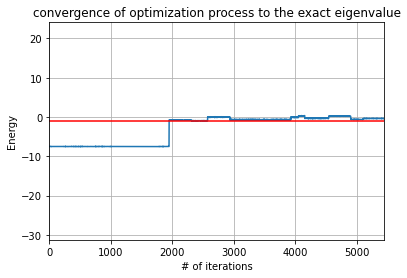

In [57]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)